# Extract Spending Data by Fiscal Year

In [1]:
import requests
import xml.etree.ElementTree as ET
import time
import pandas as pd
from pathlib import Path
import xml.dom.minidom
import math
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
API_URL = "https://www.checkbooknyc.com/api"
TEMP_XML_FILE = Path("tmp_latest_response.xml")  # same temp file each time
TIMEOUT = (300, 300) # connect_timeout, read_timeout for requests
OUTPUT_DIR = Path("checkbook_data")
OUTPUT_DIR.mkdir(exist_ok=True)
BATCH_SIZE = 20000  # API's retrieval limit on records per request

In [3]:
# session set up
session = requests.Session()
HEADERS = {
    'content-type': 'application/xml',
    'user-agent': 'mozilla/5.0 (windows nt 10.0; win64; x64) applewebkit/537.36'
}

session.headers.update(HEADERS)

# **** visit main site initially to bypass incapsula ****
response = session.get('https://www.checkbooknyc.com/', timeout=TIMEOUT)
print(f"main site status: {response.status_code}")
time.sleep(2)

session.headers.update({
    'content-type': 'application/xml',
    'referer': 'https://www.checkbooknyc.com/',
    'origin': 'https://www.checkbooknyc.com'
})

main site status: 200


## Helpers

In [4]:
def fetch_xml(payload: str, verbose: bool = False) -> ET.Element:
    response = session.post(API_URL, data=payload, headers=HEADERS, timeout=TIMEOUT)
    if verbose: 
        print(response.text[:500])
    response.raise_for_status()

    if verbose:
        xml_str = response.content.decode('utf-8')
        print(xml_str)
        
    return ET.fromstring(response.content)

def get_record_count(xml_root: ET.Element) -> int:
    count_tag = xml_root.find(".//result_records/record_count")
    return int(count_tag.text) if count_tag is not None else 0



In [5]:
y = "2025"
y[2:]

'25'

## Initial Metadata Request: Determining Pagination

In [6]:
fiscal_year = 2025

In [7]:
seed_request=f"""
<request>
  <type_of_data>Spending</type_of_data>
  <records_from>1</records_from>
  <max_records>1</max_records>
  <search_criteria>
   <criteria>
      <name>fiscal_year</name>
      <type>value</type>
      <value>{fiscal_year}</value>
    </criteria>
  </search_criteria>
  <response_columns/>
</request>
"""

In [8]:
seed_root = fetch_xml(seed_request,verbose=True)

<?xml version="1.0"?>
<response>
  <status>
    <result>success</result>
  </status>
  <request_criteria>
    <request>
      <type_of_data>Spending</type_of_data>
      <records_from>1</records_from>
      <max_records>1</max_records>
      <search_criteria>
        <criteria>
          <name>fiscal_year</name>
          <type>value</type>
          <value>2025</value>
        </criteria>
      </search_criteria>
      <response_columns/>
    </request>
  </request_criteria>
  <result_records>

<?xml version="1.0"?>
<response>
  <status>
    <result>success</result>
  </status>
  <request_criteria>
    <request>
      <type_of_data>Spending</type_of_data>
      <records_from>1</records_from>
      <max_records>1</max_records>
      <search_criteria>
        <criteria>
          <name>fiscal_year</name>
          <type>value</type>
          <value>2025</value>
        </criteria>
      </search_criteria>
      <response_columns/>
    </request>
  </request_criteria>
  <result_records>

In [9]:
retrievable_records = get_record_count(seed_root)
batches_needed = math.ceil(retrievable_records / BATCH_SIZE)

print(f"""
Seed Request Results for FY {fiscal_year}
=========================================
Total retrievable records: {retrievable_records}
Batches needed: {batches_needed}
""")


Seed Request Results for FY 2025
Total retrievable records: 3157155
Batches needed: 158



## Start Paginated Fetch-to-Appends

In [10]:
# records_from = 1
# fiscal_year = fiscal_year
# retrievable_records = retrievable_records
# max_records = min(retrievable_records, BATCH_SIZE) # otherwise response is just about exceeding request limit

# xml_batch_request=f"""
# <request>
#   <type_of_data>Spending</type_of_data>
#   <records_from>{records_from}</records_from>
#   <max_records>{max_records}</max_records>
#   <search_criteria>
#    <criteria>
#       <name>fiscal_year</name>
#       <type>value</type>
#       <value>{fiscal_year}</value>
#     </criteria>
#   </search_criteria>
#   <response_columns>
#     <column>agency</column>
#     <column>spending_category</column>
#     <column>document_id</column>
#     <column>payee_name</column>
#     <column>check_amount</column>
#     <column>department</column>
#     <column>sub_vendor</column>
#     <column>sub_contract_reference_id</column>
#     <column>fiscal_year</column>
#     <column>emerging_business</column>
#     <column>mocs_registered</column>
#     <column>expense_category</column>
#     <column>contract_id</column>
#     <column>contract_purpose</column>
#     <column>issue_date</column>
#     <column>capital_project</column>
#     <column>mwbe_category</column>
#     <column>associated_prime_vendor</column>
#     <column>industry</column>
#     <column>woman_owned_business</column>
#     <column>budget_code</column>
#   </response_columns>
# </request>
# """

# print(xml_batch_request)

## Fetch and Save FY Spending

### Function and Helpers

In [11]:
def save_parquet_simple(df: pd.DataFrame, out_file: Path) -> int:
    """simple save without deduplication for testing"""
    df.to_parquet(out_file, engine="pyarrow", index=False)
    return len(df)

In [12]:
xml_batch_request = """<request>
  <type_of_data>Spending</type_of_data>
  <records_from>{records_from}</records_from>
  <max_records>{max_records}</max_records>
  <search_criteria>
   <criteria>
      <name>fiscal_year</name>
      <type>value</type>
      <value>{fiscal_year}</value>
    </criteria>
  </search_criteria>
  <response_columns>
    <column>agency</column>
    <column>spending_category</column>
    <column>document_id</column>
    <column>payee_name</column>
    <column>check_amount</column>
    <column>department</column>
    <column>sub_vendor</column>
    <column>sub_contract_reference_id</column>
    <column>fiscal_year</column>
    <column>emerging_business</column>
    <column>mocs_registered</column>
    <column>expense_category</column>
    <column>contract_id</column>
    <column>contract_purpose</column>
    <column>issue_date</column>
    <column>capital_project</column>
    <column>mwbe_category</column>
    <column>associated_prime_vendor</column>
    <column>industry</column>
    <column>woman_owned_business</column>
    <column>budget_code</column>
  </response_columns>
</request>"""

In [13]:
# add this detailed duplicate analysis
def analyze_false_duplicates(df: pd.DataFrame):
    """debug why pandas thinks different rows are duplicates"""
    
    # get "duplicate" rows
    dup_mask = df.duplicated(keep=False)
    dup_rows = df[dup_mask]
    
    if len(dup_rows) < 2:
        print("no duplicates to analyze")
        return
    
    print(f"analyzing {len(dup_rows)} 'duplicate' rows")
    
    # compare first two rows that pandas considers duplicates
    row1 = dup_rows.iloc[0].copy()
    row2 = dup_rows.iloc[1].copy()
    
    print(f"\ncomparing rows {dup_rows.index[0]} vs {dup_rows.index[1]}:")
    
    all_identical = True
    for col in df.columns:
        val1 = row1[col]
        val2 = row2[col]
        
        # handle different data types and nan values
        if pd.isna(val1) and pd.isna(val2):
            status = "both nan"
        elif pd.isna(val1) or pd.isna(val2):
            status = "one nan, one not"
            all_identical = False
        elif str(val1) == str(val2):
            status = "identical"
        else:
            status = f"DIFFERENT: '{val1}' vs '{val2}'"
            all_identical = False
        
        print(f"  {col}: {status}")
    
    print(f"\nall columns identical: {all_identical}")
    
    # check if issue is with data types or hidden characters
    if not all_identical:
        print("\nchecking for hidden issues:")
        for col in ['check_amount', 'issue_date', 'document_id']:
            if col in df.columns:
                val1, val2 = row1[col], row2[col]
                print(f"{col}:")
                print(f"  val1: '{val1}' (type: {type(val1)}, len: {len(str(val1))})")
                print(f"  val2: '{val2}' (type: {type(val2)}, len: {len(str(val2))})")
                print(f"  equal: {val1 == val2}")

In [14]:
tqdm._instances.clear()

def save_parquet_append(df: pd.DataFrame, out_file: Path) -> int:
    out_file = Path(out_file)
    if out_file.exists():
        try:
            pa.unregister_extension_type("pandas.period")
        except KeyError:
            pass
        existing_df = pd.read_parquet(out_file, engine="pyarrow")
        original_count = len(existing_df)
        combined = pd.concat([existing_df, df], ignore_index=True)
        deduped = combined.drop_duplicates()
        
        # fix: calculate actual new records added
        final_count = len(deduped)
        new_records_attempted = len(df)
        
        # net change can be negative, but "added" should be non-negative
        net_change = final_count - original_count
        actually_added = max(0, net_change)  # never negative
        
        deduped.to_parquet(out_file, engine="pyarrow", index=False)
        return actually_added
    else:
        df.to_parquet(out_file, engine="pyarrow", index=False)
        return len(df)

        
def parse_transactions(xml_root: ET.Element) -> pd.DataFrame:
    """convert <transaction> elements into dataframe rows"""
    records = []
    for txn in xml_root.findall(".//transaction"):
        row = {child.tag: (child.text or "").strip() for child in txn}
        records.append(row)
    return pd.DataFrame(records)

def download_spending_by_FY(xml_batch_request: str,
                            year: int,
                            retrievable_records: int,
                            records_to_retrieve: int,
                            verbose: bool=True):
    total_to_fetch = min(retrievable_records, records_to_retrieve)
    
    if verbose:
        print(f"FY{year} download: available={retrievable_records:,}, "
              f"requesting={records_to_retrieve:,}")
    
    # create progress bar right before loop starts
    total_saved = 0
    total_dropped = 0
    records_processed = 0
    offset = 1
    
    # calculate batches based on actual request
    total_batches = math.ceil(total_to_fetch / BATCH_SIZE)
    out_file = OUTPUT_DIR / f"spending_{year}.parquet"
    
    with tqdm(total=total_to_fetch, desc=f"FY{year}", unit="records", ncols=80) as pbar:
        for batch_num in range(1, total_batches + 1):
            remaining = total_to_fetch - records_processed
            if remaining <= 0:
                break
                
            records_this_batch = min(BATCH_SIZE, remaining)
            
            # make request
            
            xml_body = xml_batch_request.format(
                records_from=offset,
                max_records=records_this_batch,
                fiscal_year=year 
            )

            response = session.post(API_URL, data=xml_body, timeout=TIMEOUT)

           # check response
            if response.text.strip().startswith('<html'):
                tqdm.write(f"batch {batch_num}: blocked by incapsula")
                break


            # add debug:
            print(f"xml sent: {xml_body}")
            print(f"response preview: {response.text[:500]}")
            
            # also check if api returned success but no transactions
            root = ET.fromstring(response.text.strip())
            status = root.find('.//status/result')
            record_count = root.find('.//record_count')
            print(f"api status: {status.text if status is not None else 'missing'}")
            print(f"record count: {record_count.text if record_count is not None else 'missing'}")
                        
             
            try:
                root = ET.fromstring(response.text.strip())
                df = parse_transactions(root)

                # add this debug block here:
                print("checking for patterns in data:")
                print(f"unique document_ids: {df['document_id'].nunique()}")
                print(f"unique payee_names: {df['payee_name'].nunique()}")
                print(f"total rows: {len(df)}")
                dupes_in_batch = df.duplicated().sum()
                print(f"duplicates within single batch: {dupes_in_batch}")
                print("first 3 rows:")
                print(df.head(3))


                # replace the duplicate checking code with this more detailed version:
                if dupes_in_batch > 0:
                    print(f"\nfound {dupes_in_batch} duplicates within batch")
                    analyze_false_duplicates(df)
                    
                    # get first duplicate pair to examine closely
                    duplicate_mask = df.duplicated(keep=False)
                    duplicate_rows = df[duplicate_mask]
                    
                    if len(duplicate_rows) >= 2:
                        # compare first two "duplicate" rows column by column
                        row1 = duplicate_rows.iloc[0]
                        row2 = duplicate_rows.iloc[1]
                        
                        print("comparing first two 'duplicate' rows:")
                        print("row 1 index:", duplicate_rows.index[0])
                        print("row 2 index:", duplicate_rows.index[1])
                        
                        differences = []
                        for col in df.columns:
                            val1 = row1[col]
                            val2 = row2[col]
                            
                            if pd.isna(val1) and pd.isna(val2):
                                continue  # both nan, truly equal
                            elif val1 != val2:
                                differences.append(f"{col}: '{val1}' vs '{val2}'")
                        
                        if differences:
                            print(f"found {len(differences)} differences:")
                            for diff in differences[:10]:  # show first 10 differences
                                print(f"  {diff}")
                        else:
                            print("no differences found - rows are truly identical")
                            
                        # check data types
                        print("data types check:")
                        for col in df.columns[:5]:
                            print(f"  {col}: {df[col].dtype}")

                # verify expected len
                if len(df) != records_this_batch:
                    tqdm.write(f"warning: requested {records_this_batch}, got {len(df)}")
                
            except ET.ParseError:
                tqdm.write(f"batch {batch_num}: xml parse error")
                break
            
            # save and track
            
            # TODO: UNDO TEMP FOR DEBUG: replace with debug version
            # added = save_parquet_append(df, out_file)
            added = save_parquet_append_debug(df, out_file)

            dropped = len(df) - added
            
            total_saved += added
            total_dropped += dropped
            records_processed += len(df)
            
            # update progress by records intended to process (regardless of duplicate; just whether 'seen')
            pbar.update(records_this_batch)
            
            if verbose:
                tqdm.write(f"batch {batch_num}: got {len(df)}, saved {added}, dropped {dropped}")
            
            offset += records_this_batch
            time.sleep(1.1)
    
    if verbose:
        print(f"complete: {total_saved:,} saved, {total_dropped:,} dropped")

In [15]:
def save_parquet_append_debug(df: pd.DataFrame, out_file: Path) -> int:
    out_file = Path(out_file)
    
    if out_file.exists():
        existing_df = pd.read_parquet(out_file, engine="pyarrow")
        combined = pd.concat([existing_df, df], ignore_index=True)
        
        # identify duplicates before removing them
        duplicate_mask = combined.duplicated(keep='first')
        dropped_rows = combined[duplicate_mask]
        
        if len(dropped_rows) > 0:
            # save duplicates to inspection file
            duplicate_file = out_file.parent / f"duplicates_{out_file.stem}.parquet"
            
            if duplicate_file.exists():
                existing_dupes = pd.read_parquet(duplicate_file)
                all_dupes = pd.concat([existing_dupes, dropped_rows], ignore_index=True)
            else:
                all_dupes = dropped_rows
                
            all_dupes.to_parquet(duplicate_file, engine="pyarrow", index=False)
            print(f"saved {len(dropped_rows)} duplicates to {duplicate_file}")
            
            # also save first few for quick inspection
            sample_file = out_file.parent / f"duplicate_sample_{out_file.stem}.csv"
            dropped_rows.head(10).to_csv(sample_file, index=False)
            print(f"sample duplicates saved to {sample_file}")
        
        # proceed with normal deduplication
        deduped = combined.drop_duplicates()
        deduped.to_parquet(out_file, engine="pyarrow", index=False)
        return max(0, len(deduped) - len(existing_df))
    else:
        df.to_parquet(out_file, engine="pyarrow", index=False)
        return len(df)

### Function Calls

In [16]:
retrievable_records
# records_to_retrieve = 1
records_to_retrieve = 20000

download_spending_by_FY(
    xml_batch_request, 
    year=fiscal_year, 
    retrievable_records=retrievable_records, 
    records_to_retrieve=records_to_retrieve,
)

FY2025 download: available=3,157,155, requesting=20,000


FY2025:   0%|                                    | 0/20000 [00:00<?, ?records/s]

xml sent: <request>
  <type_of_data>Spending</type_of_data>
  <records_from>1</records_from>
  <max_records>20000</max_records>
  <search_criteria>
   <criteria>
      <name>fiscal_year</name>
      <type>value</type>
      <value>2025</value>
    </criteria>
  </search_criteria>
  <response_columns>
    <column>agency</column>
    <column>spending_category</column>
    <column>document_id</column>
    <column>payee_name</column>
    <column>check_amount</column>
    <column>department</column>
    <column>sub_vendor</column>
    <column>sub_contract_reference_id</column>
    <column>fiscal_year</column>
    <column>emerging_business</column>
    <column>mocs_registered</column>
    <column>expense_category</column>
    <column>contract_id</column>
    <column>contract_purpose</column>
    <column>issue_date</column>
    <column>capital_project</column>
    <column>mwbe_category</column>
    <column>associated_prime_vendor</column>
    <column>industry</column>
    <column>woman_owned_

FY2025: 100%|██████████████████████| 20000/20000 [00:06<00:00, 2858.66records/s]

saved 20185 duplicates to checkbook_data/duplicates_spending_2025.parquet
sample duplicates saved to checkbook_data/duplicate_sample_spending_2025.csv
batch 1: got 20000, saved 0, dropped 20000


FY2025: 100%|██████████████████████| 20000/20000 [00:08<00:00, 2468.18records/s]

complete: 0 saved, 20,000 dropped


## Peek in Parquet File

In [17]:
# file_path = "checkbook_data/spending_2025.parquet"
file_path = "checkbook_data/duplicates_spending_2025.parquet"


# read the Parquet file into a DataFrame
df = pd.read_parquet(file_path, engine="pyarrow") 

# look at the first few rows
print(df.head())

# see general info
print(df.info())

# get column names
print(df.columns)

         agency associated_prime_vendor                          budget_code  \
0  Debt Service                     N/A  4001 (BUDGET STABILIZATION ACCOUNT)   
1  Debt Service                     N/A  4001 (BUDGET STABILIZATION ACCOUNT)   
2  Debt Service                     N/A  4001 (BUDGET STABILIZATION ACCOUNT)   
3  Debt Service                     N/A  4001 (BUDGET STABILIZATION ACCOUNT)   
4  Debt Service                     N/A  4001 (BUDGET STABILIZATION ACCOUNT)   

  capital_project contract_id mocs_registered contract_purpose check_amount  \
0                                          No                   99000000.00   
1                                          No                   99000000.00   
2                                          No                   99000000.00   
3                                          No                   99000000.00   
4                                          No                   99000000.00   

                     department            d

In [18]:
def save_parquet_append_debug(df: pd.DataFrame, out_file: Path) -> int:
    out_file = Path(out_file)
    print(f"input df shape: {df.shape}")
    
    if out_file.exists():
        existing_df = pd.read_parquet(out_file, engine="pyarrow")
        print(f"existing file shape: {existing_df.shape}")
        
        # check for duplicates before combining
        input_dupes = df.duplicated().sum()
        print(f"duplicates within input df: {input_dupes}")
        
        combined = pd.concat([existing_df, df], ignore_index=True)
        print(f"combined shape: {combined.shape}")
        
        # identify what gets dropped
        before_dedup = len(combined)
        deduped = combined.drop_duplicates()
        after_dedup = len(deduped)
        dropped_count = before_dedup - after_dedup
        
        print(f"dropped in deduplication: {dropped_count}")
        
        if dropped_count > 0:
            # find the duplicate rows
            duplicated_mask = combined.duplicated(keep='first')
            dropped_rows = combined[duplicated_mask]
            
            print(f"sample of dropped rows:")
            print(dropped_rows.head())
            
            # check which columns have the most duplicates
            for col in df.columns[:5]:  # check first 5 columns
                unique_vals = dropped_rows[col].nunique()
                print(f"column {col}: {unique_vals} unique values in dropped rows")
        
        deduped.to_parquet(out_file, engine="pyarrow", index=False)
        return max(0, after_dedup - len(existing_df))
    else:
        df.to_parquet(out_file, engine="pyarrow", index=False)
        return len(df)

In [19]:
# check what actually got saved
out_file = OUTPUT_DIR / f"spending_{fiscal_year}.parquet"
if out_file.exists():
    df_check = pd.read_parquet(out_file)
    print(f"file exists: {len(df_check)} records")
else:
    print("no file created")
    
# check if xml was saved
xml_files = list(OUTPUT_DIR.glob("raw_FY*.xml"))
print(f"xml files: {len(xml_files)}")

file exists: 19815 records
xml files: 6


###  API Notes

https://www.checkbooknyc.com/spending-api

- retrieval limit: 20K records per call
- FY25: 3.2M transactions 
- to retrieve all: stagger `records_from` 

3,157,063 transactions <- as of 8/22 from data feeds https://www.checkbooknyc.com/data-feeds 

##### XML request:
- global params: `type_of_data`, `records_from`, `max_records`
- filters: put in `<search_criteria>`
- requested columns: put in `<response_columns>`

##### XML response: 
- `<search_criteria>`: echoes request xml
- `<result_records>`: current result batch based on `records_from` and `max_records`
- `<record_count>`: TOTAL rows
- `<messages>`: errors + status info
- `<status>`: success/failure of request

## to sanity check

??
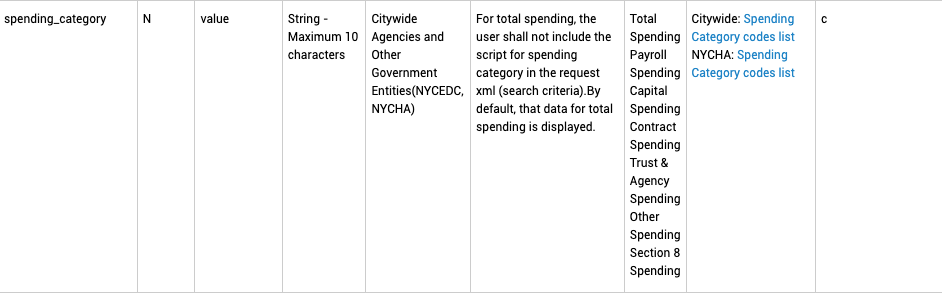